In [1]:
import numpy as np
import matplotlib.pyplot as plt

dims = 1000.0 # the side length of the squar-shaped field

In [2]:
##############################################################################
# This function will give you two local optima
##############################################################################
# def fitness_function(xx, yy): # two targets
#     x = xx/200
#     y = yy/200
#     return 16 - ((x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73))

In [3]:
# ##############################################################################
# # Three-Hump Camel function:
# # There will be three local optima in the search field
# ##############################################################################
# def fitness_function(x, y): 
#     x1 = x/180 - 2.9
#     x2 = y/180 - 2.9
#     # The formula for the Three-Hump Camel function
#     f_x = np.log(2 * x1**2 - 1.05 * x1**4 + (x1**6) / 6 + x1 * x2 + x2**2)
#     return (5-f_x)/10

In [6]:
##############################################################################
# Easom function:
# Easom function is a round-shaped field, you can decided how many optima you
# like to use in a field by adding more Easom functions in different locations
##############################################################################
def Easom(x,y):
    return np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))

# def fitness_function(xx,yy): # one optimum
#     x = xx/200 - 0.5
#     y = yy/200 - 0.5
#     return Easom(x,y)

# def fitness_function(xx,yy): # two optima
#     x1 = xx/200 - 0.5
#     y1 = yy/200 - 0.5
#     z1 = Easom(x1,y1)
#     x2 = xx/180 + 2
#     y2 = yy/180 + 2
#     z2 = Easom(x2,y2)
#     return z1 + 0.7 * z2

# def fitness_function(xx,yy): # three optima
#     x1 = xx/200 - 0.5
#     y1 = yy/200 - 0.5
#     z1 = Easom(x1,y1)
#     x2 = xx/180 + 2
#     y2 = yy/180 + 2
#     z2 = Easom(x2,y2)
#     x3 = xx/180 + 2
#     y3 = yy/180 - 1
#     z3 = Easom(x3,y3)
#     return z1 + 0.7 * z2 + 0.7 * z3

def fitness_function(xx, yy): # four optima
    x1 = xx/200 - 0.5
    y1 = yy/200 - 0.5
    z1 = Easom(x1,y1)
    x2 = xx/200 + 2
    y2 = yy/200 + 2
    z2 = Easom(x2,y2)
    x3 = xx/200 + 2
    y3 = yy/200 - 0.7
    z3 = Easom(x3,y3)
    x4 = xx/200 - 0.7
    y4 = yy/200 + 2
    z4 = Easom(x4,y4)
    return z1 + 0.7 * z2 + 0.7 * z3 + 0.7 * z4

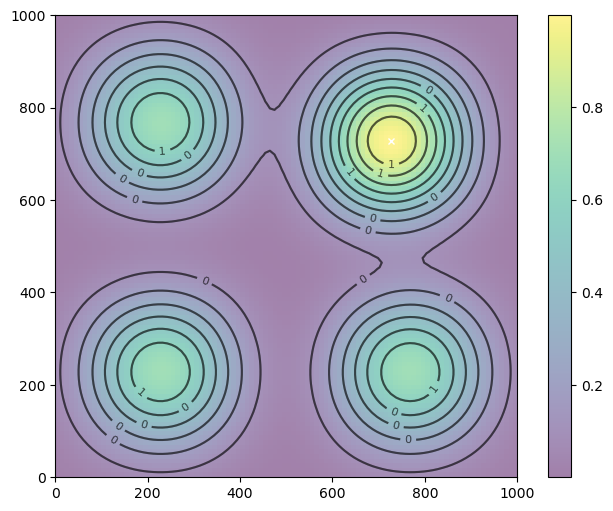

In [ ]:
# Plotting
x, y = np.array(np.meshgrid(np.linspace(0, dims, 100), np.linspace(0, dims, 100)))
z = fitness_function(x, y)
x_max, y_max = x.ravel()[z.argmax()], y.ravel()[z.argmax()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, dims, 0, dims], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_max], [y_max], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial.distance import pdist, squareform

In [2]:
# --- Environment and Simulation Constants ---
AREA_SIZE = 1000
NUM_AUVS = 25
COMM_RANGE = 250.0  # Communication range in meters
SIM_STEPS = 150     # Total number of simulation iterations
MOVE_STEP = 15.0    # How far an AUV moves in one step
CONVERGENCE_THRESHOLD = 1.0 # Movement threshold to be considered 'converged'

In [3]:
# --- Fitness Function (The Signal Landscape) ---
# Note: The standard Easom function has a minimum. We invert it by taking the
# negative, so that the peaks we want to find are maxima (for hill-climbing).
def easom_inverted(x, y):
    """Calculates the inverted Easom function value."""
    return -np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))

def fitness_function(xx, yy):
    """
    Calculates the total signal strength at world coordinates (xx, yy).
    This function combines four weighted Easom functions to create four targets.
    """
    # Target 1 (100% strength)
    # Peak is at approx. (728, 728)
    x1 = (xx / 200.0) - 0.5
    y1 = (yy / 200.0) - 0.5
    z1 = easom_inverted(x1, y1)

    # Target 2 (70% strength)
    # Peak is at approx. (205, 205)
    x2 = (xx / 180.0) + 2.0
    y2 = (yy / 180.0) + 2.0
    z2 = easom_inverted(x2, y2)

    # Target 3 (70% strength)
    # Peak is at approx. (205, 745)
    x3 = (xx / 180.0) + 2.0
    y3 = (yy / 180.0) - 1.0
    z3 = easom_inverted(x3, y3)

    # Target 4 (70% strength)
    # Peak is at approx. (745, 205)
    x4 = (xx / 180.0) - 1.0
    y4 = (yy / 180.0) + 2.0
    z4 = easom_inverted(x4, y4)

    return z1 + 0.7 * z2 + 0.7 * z3 + 0.7 * z4


In [4]:
# --- AUV Agent Class ---
class AUV:
    """Represents a single Autonomous Underwater Vehicle."""
    def __init__(self, id, pos):
        self.id = id
        self.pos = np.array(pos, dtype=float)
        self.state = 'EXPLORING'  # Initial state
        
        # Dictionary to store data about discovered peaks
        # Format: {peak_coord_tuple: {'strength': S, 'population': N}}
        self.known_peaks = {}
        
        self.target_pos = None  # Target for reallocation
        self.movement_history = [] # Used to check for convergence

    def get_peak_id(self, pos):
        """Generates a unique ID for a peak based on its rounded coordinates."""
        return tuple(np.round(pos / 150) * 150)

    def update(self, all_auvs, dist_matrix):
        """Main update logic for the AUV, called each simulation step."""
        # 1. Find neighbors within communication range
        my_index = self.id
        neighbor_indices = np.where((dist_matrix[my_index] > 0) & (dist_matrix[my_index] < COMM_RANGE))[0]
        neighbors = [all_auvs[i] for i in neighbor_indices]
        
        # --- State Machine Logic ---
        if self.state == 'EXPLORING':
            self.explore()
            # Check for convergence to switch state
            if len(self.movement_history) == 5 and np.mean(self.movement_history) < CONVERGENCE_THRESHOLD:
                self.state = 'CONVERGED'
                self.movement_history = []

        elif self.state == 'CONVERGED':
            self.perform_consensus(neighbors)

        elif self.state == 'REALLOCATING':
            self.reallocate()

    def explore(self):
        """State 1: Move towards a stronger signal (Hill-climbing)."""
        best_pos = self.pos
        max_fitness = fitness_function(self.pos[0], self.pos[1])

        # Sample 8 directions to find the best way to move
        for angle in np.linspace(0, 2 * np.pi, 8):
            test_pos = self.pos + MOVE_STEP * np.array([np.cos(angle), np.sin(angle)])
            test_pos = np.clip(test_pos, 0, AREA_SIZE) # Stay within bounds
            
            current_fitness = fitness_function(test_pos[0], test_pos[1])
            if current_fitness > max_fitness:
                max_fitness = current_fitness
                best_pos = test_pos
        
        # Track movement to see if we've stopped at a peak
        self.movement_history.append(np.linalg.norm(best_pos - self.pos))
        if len(self.movement_history) > 5:
            self.movement_history.pop(0)
        
        self.pos = best_pos

    def perform_consensus(self, neighbors):
        """State 2: Share info and decide if this peak is over-populated."""
        # Identify the peak this AUV is at
        my_peak_id = self.get_peak_id(self.pos)
        my_strength = fitness_function(self.pos[0], self.pos[1])
        
        # Estimate local population (self + neighbors at the same peak)
        my_population = 1
        for neighbor in neighbors:
            if self.get_peak_id(neighbor.pos) == my_peak_id:
                my_population += 1

        # Update my own knowledge
        self.known_peaks[my_peak_id] = {'strength': my_strength, 'population': my_population}

        # Gossip: Exchange peak information with all neighbors
        for neighbor in neighbors:
            self.known_peaks.update(neighbor.known_peaks)

        # Decision logic: Should I leave?
        total_strength = sum(p['strength'] for p in self.known_peaks.values() if p.get('strength'))
        if total_strength > 0 and len(self.known_peaks) > 1: # Only decide if we know of >1 peak
            my_peak_info = self.known_peaks.get(my_peak_id)
            if not my_peak_info: return

            # Calculate ideal population for my peak
            ideal_pop = NUM_AUVS * (my_peak_info['strength'] / total_strength)
            
            # If we are over-populated (with a buffer to prevent frantic switching)
            if my_peak_info['population'] > ideal_pop + 1:
                self.find_new_target(my_peak_id, total_strength)

    def find_new_target(self, my_peak_id, total_strength):
        """Find the most under-populated peak to move to."""
        best_target_peak_id = None
        max_need = -np.inf

        for pid, pinfo in self.known_peaks.items():
            if pid != my_peak_id and pinfo.get('strength'):
                ideal_pop = NUM_AUVS * (pinfo['strength'] / total_strength)
                current_pop = pinfo.get('population', 1)
                need = ideal_pop - current_pop
                if need > max_need:
                    max_need = need
                    best_target_peak_id = pid
        
        if best_target_peak_id:
            self.state = 'REALLOCATING'
            self.target_pos = np.array(best_target_peak_id)

    def reallocate(self):
        """State 3: Move towards the designated under-populated target."""
        if self.target_pos is None:
            self.state = 'EXPLORING'
            return

        direction = self.target_pos - self.pos
        dist_to_target = np.linalg.norm(direction)

        if dist_to_target < MOVE_STEP * 2: # We have arrived
            self.state = 'EXPLORING'
            self.target_pos = None
        else: # Move towards the target
            self.pos += (direction / dist_to_target) * MOVE_STEP
            self.pos = np.clip(self.pos, 0, AREA_SIZE)

In [5]:
# --- Main Simulation Setup ---
# 1. Create the background fitness landscape for plotting
x_grid = np.linspace(0, AREA_SIZE, 200)
y_grid = np.linspace(0, AREA_SIZE, 200)
xx, yy = np.meshgrid(x_grid, y_grid)
zz = fitness_function(xx, yy)

# 2. Initialize the 25 AUVs on their starting grid
auvs = [AUV(i, ((i % 5) * 225 + 50, int(i / 5) * 225 + 50)) for i in range(NUM_AUVS)]
initial_positions = np.array([auv.pos for auv in auvs])

# --- Run Simulation ---
history = []
for step in range(SIM_STEPS):
    # Store positions at the start of the step for animation
    current_positions = np.array([auv.pos for auv in auvs])
    history.append(current_positions)
    
    # Pre-calculate all pairwise distances for efficiency
    dist_matrix = squareform(pdist(current_positions))
    
    # Update each AUV
    for auv in auvs:
        auv.update(auvs, dist_matrix)

c:\Users\byang12\AppData\Local\anaconda3\Lib\site-packages\matplotlib\animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


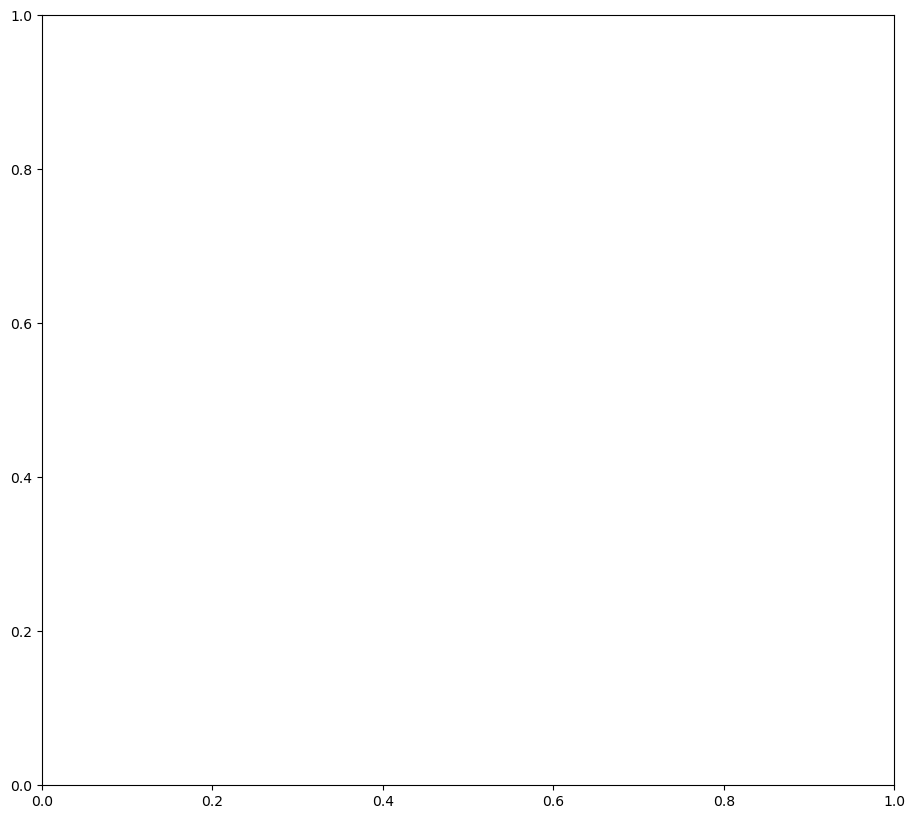

MovieWriter imagemagick unavailable; using Pillow instead.


In [7]:
# --- Animation ---
fig, ax = plt.subplots(figsize=(11, 10))

def animate(frame):
    ax.clear()
    # Plot the fitness landscape background
    ax.contourf(xx, yy, zz, levels=50, cmap='viridis', zorder=0)
    
    # Plot the AUVs at the current frame
    positions = history[frame]
    ax.scatter(positions[:, 0], positions[:, 1], c='red', edgecolors='white', s=70, zorder=5, label='AUVs')
    
    # Plot initial positions for reference
    ax.scatter(initial_positions[:, 0], initial_positions[:, 1], c='cyan', marker='x', s=50, zorder=4, label='Initial Positions')

    ax.set_title(f'AUV Swarm Allocation | Step: {frame+1}/{SIM_STEPS}', fontsize=16)
    ax.set_xlabel('X Coordinate (meters)')
    ax.set_ylabel('Y Coordinate (meters)')
    ax.set_xlim(0, AREA_SIZE)
    ax.set_ylim(0, AREA_SIZE)
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    
    # On the final frame, display the allocation results
    if frame == SIM_STEPS - 1:
        final_positions = history[-1]
        peak_counts = {}
        for pos in final_positions:
            # Use the same rounding logic to group AUVs by peak
            peak_id = tuple(np.round(pos / 150) * 150)
            peak_counts[peak_id] = peak_counts.get(peak_id, 0) + 1
        
        text_y = AREA_SIZE * 0.98
        ax.text(AREA_SIZE * 0.02, text_y, 'Final Allocation:', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.9))
        for peak, count in sorted(peak_counts.items(), key=lambda item: item[1], reverse=True):
            text_y -= AREA_SIZE * 0.06
            ax.text(AREA_SIZE * 0.02, text_y, f'Target @ {peak}: {count} AUVs',
                    bbox=dict(facecolor='white', alpha=0.9), fontsize=12)

# Create and display the animation
ani = animation.FuncAnimation(fig, animate, frames=len(history), interval=75)
plt.show()

# To save the animation as a GIF (requires ImageMagick):
ani.save('auv_allocation.gif', writer='imagemagick', fps=15)